# Implementation of Deep Convolutional GANs
Reference: https://arxiv.org/pdf/1511.06434.pdf

In [1]:
import torch
print(torch.__version__)   

2.10.0+cpu


In [ ]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
import numpy as np
import datetime
import os, sys

In [ ]:
import glob

In [ ]:
from PIL import Image

In [ ]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [ ]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
IMAGE_DIM = (32, 32, 3)

In [ ]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(10, n_noise).to(DEVICE)
    # Changed view from (10, 3, 28, 28) to (10, 3, 32, 32) for CIFAR-10 (IMAGE_DIM)
    y_hat = G(z).view(10, IMAGE_DIM[2], IMAGE_DIM[0], IMAGE_DIM[1]).permute(0, 2, 3, 1)
    result = (y_hat.detach().cpu().numpy()+1)/2.
    return result

In [ ]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            #
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [ ]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, out_channel=1, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        assert IMAGE_DIM[0] % 2**4 == 0, 'Should be divided 16'
        self.init_dim = (IMAGE_DIM[0] // 2**4, IMAGE_DIM[1] // 2**4)
        self.fc = nn.Sequential(
            nn.Linear(input_size, self.init_dim[0]*self.init_dim[1]*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, out_channel, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, self.init_dim[0], self.init_dim[1])
        y_ = self.conv(y_)
        return y_

In [ ]:
class CARS(Dataset):
    '''
    CARS Dataset
    You should download this dataset from below url.
    url: https://ai.stanford.edu/~jkrause/cars/car_dataset.html
    '''
    def __init__(self, data_path, transform=None):
        '''
        Args:
            data_path (str): path to dataset
        '''
        self.data_path = data_path
        self.transform = transform
        self.fpaths = sorted(glob.glob(os.path.join(data_path, '*.jpg')))
        gray_lst = [266, 1085, 2176, 3048, 3439, 3469, 3539, 4577, 4848, 5177, 5502, 5713, 6947, 7383, 7693, 7774, 8137, 8144]
        for num in gray_lst:
            self.fpaths.remove(os.path.join(data_path, '{:05d}.jpg'.format(num)))

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.fpaths[idx]))
        return img

    def __len__(self):
        return len(self.fpaths)

In [ ]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1]).to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [ ]:
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ]
)

In [ ]:
# Load CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

In [ ]:
batch_size = 64

In [ ]:
# Adjusted num_workers for better compatibility, especially in Colab environments
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)

In [ ]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

In [ ]:
max_epoch = 100
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [ ]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [ ]:
for epoch in range(max_epoch):
    for idx, images in enumerate(data_loader):
        # Training Discriminator
        x = images[0].to(DEVICE) # Corrected: Access the image tensor
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), dt))
            G.eval()
            # Ensure 'samples' directory exists
            if not os.path.exists('samples'):
                os.makedirs('samples')
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{:05d}.jpg'.format(MODEL_NAME, step), img[0])
            G.train()
        step += 1

Epoch: 0/100, Step: 0, D Loss: 1.4035, G Loss: 0.6256, Time:06:27:48
Epoch: 0/100, Step: 500, D Loss: 0.8995, G Loss: 1.7353, Time:07:03:47
Epoch: 1/100, Step: 1000, D Loss: 1.2727, G Loss: 1.7406, Time:07:39:47
Epoch: 1/100, Step: 1500, D Loss: 1.1985, G Loss: 1.7363, Time:08:15:48
Epoch: 2/100, Step: 2000, D Loss: 1.0066, G Loss: 1.6469, Time:08:52:23
Epoch: 3/100, Step: 2500, D Loss: 1.2231, G Loss: 1.7309, Time:09:28:56


## Sample

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise)[0])

In [ ]:
# Real Image
t = Image.open(dataset.fpaths[999])
t = (transform(t).permute(1, 2, 0)+1)/2.
imshow(t)

In [ ]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [ ]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1,
                 'D':D.state_dict(),
                 'G':G.state_dict(),
                 'd_optim': D_opt.state_dict(),
                 'g_optim' : G_opt.state_dict()},
                'dcgan.pth.tar')

Discriminator Created
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
Generato

100%|██████████| 169M/169M [00:03<00:00, 46.4MB/s]


Starting Training Loop....
[1/50][0/391] Loss_D:1.5280 Loss_G: 3.4917
[1/50][100/391] Loss_D:0.3242 Loss_G: 4.6318
[1/50][200/391] Loss_D:0.9707 Loss_G: 6.9297
[1/50][300/391] Loss_D:0.4389 Loss_G: 3.8499
Saved image: cifar100_epoch_1.png
[2/50][0/391] Loss_D:0.5962 Loss_G: 3.7677
[2/50][100/391] Loss_D:0.8126 Loss_G: 3.7393
[2/50][200/391] Loss_D:0.3437 Loss_G: 3.1407
[2/50][300/391] Loss_D:0.3923 Loss_G: 4.4836
[3/50][0/391] Loss_D:0.4912 Loss_G: 4.9677
[3/50][100/391] Loss_D:0.4421 Loss_G: 3.4601
[3/50][200/391] Loss_D:0.4487 Loss_G: 5.2077
[3/50][300/391] Loss_D:0.2790 Loss_G: 4.2111
[4/50][0/391] Loss_D:0.6986 Loss_G: 6.3208
[4/50][100/391] Loss_D:0.3133 Loss_G: 4.3573
[4/50][200/391] Loss_D:0.4329 Loss_G: 5.6347
[4/50][300/391] Loss_D:0.5985 Loss_G: 3.3145
[5/50][0/391] Loss_D:0.8196 Loss_G: 3.8165
[5/50][100/391] Loss_D:0.6699 Loss_G: 3.9285
[5/50][200/391] Loss_D:0.4968 Loss_G: 3.1768
[5/50][300/391] Loss_D:0.7267 Loss_G: 4.1998
[6/50][0/391] Loss_D:0.6175 Loss_G: 2.7184
[6/50]

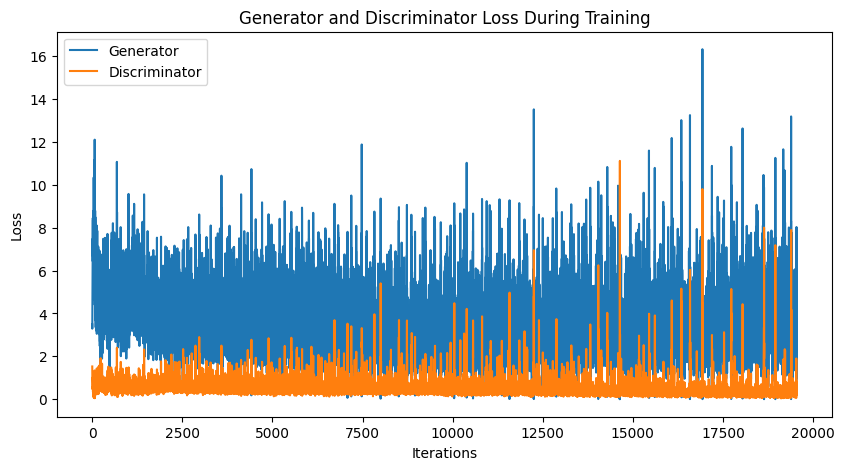

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import datetime
import os,sys

MODEL_NAME= 'DCGAN_CIFAR100'
DEVICE= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE= 128
IMAGE_SIZE= 32
NZ=100
NGF= 64
NDF= 64
LR= 0.0002
BETA1= 0.5
EPOCHS= 50

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=NDF,kernel_size=4, stride=2,padding= 1,bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(in_channels=NDF,out_channels=NDF*2,kernel_size=4,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(NDF*2),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(in_channels=NDF*2,out_channels= NDF*4,kernel_size=4, stride=2, padding=1, bias= False),
        nn.BatchNorm2d(NDF*4),
        nn.LeakyReLU(0.2, inplace= True),

        nn.Conv2d(in_channels=NDF*4,out_channels=NDF*8 ,kernel_size=4, stride=2, padding=1,bias=False),
        nn.BatchNorm2d(NDF*8),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(in_channels=NDF*8, out_channels=1,kernel_size=2, stride=1, padding=0, bias=False),
        nn.Sigmoid()
    )
  def forward(self,input):
      return self.main(input)
netD= Discriminator().to(DEVICE)
print("Discriminator Created")
print(netD)



class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(

        nn.ConvTranspose2d(in_channels=NZ, out_channels=NGF*8,kernel_size=2, stride=1, padding=0, bias= False),
        nn.BatchNorm2d(NGF*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=NGF*8, out_channels=NGF*4, kernel_size=4, stride= 2, padding=1,bias=False),
        nn.BatchNorm2d(NGF*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=NGF*4, out_channels=NGF*2,kernel_size=4,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(NGF*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=NGF*2, out_channels=NGF, kernel_size=4, stride=2, padding=1, bias =False),
        nn.BatchNorm2d(NGF),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=NGF, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )
  def forward(self,input):
       return self.main(input)
netG= Generator().to(DEVICE)
print("Generator Created")
print(netG)


import matplotlib.pyplot as plt


print("Loading CIFAR-100 Dataset...")
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset= datasets.CIFAR100(root='./data', train= True, download= True, transform=transform)
dataloader= DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)


def weights_init(m):
  classname= m.__class__.__name__
  if 'Conv' in classname:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif 'BatchNorm' in classname:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)


netG.apply(weights_init)
netD.apply(weights_init)

criterion= nn.BCELoss()
optimizerD= torch.optim.Adam(netD.parameters(), lr=LR, betas=(BETA1,0.999))
optimizerG= torch.optim.Adam(netG.parameters(), lr=LR, betas=(BETA1,0.999))
img_list=[]
G_losses=[]
D_losses=[]

print("Starting Training Loop....")

for epoch in range(EPOCHS):
  for i, data in enumerate(dataloader,0):
      netD.zero_grad()
      real_cpu= data[0].to(DEVICE)
      b_size= real_cpu.size(0)
      label= torch.full((b_size,), 1., dtype=torch.float, device=DEVICE)

      output= netD(real_cpu).view(-1)
      errD_real= criterion(output, label)
      errD_real.backward()

      noise= torch.randn(b_size,NZ, 1,1, device=DEVICE)
      fake= netG(noise)
      label.fill_(0.)

      output= netD(fake.detach()).view(-1)
      errD_fake= criterion(output, label)
      errD_fake.backward()

      errD= errD_real+errD_fake
      optimizerD.step()

      netG.zero_grad()
      label.fill_(1.)

      output= netD(fake).view(-1)
      errG = criterion(output, label)
      errG.backward()

      optimizerG.step()

      G_losses.append(errG.item())
      D_losses.append(errD.item())

      if i% 100 ==0:
        print(f'[{epoch+1}/{EPOCHS}][{i}/{len(dataloader)}] Loss_D:{errD.item():.4f} Loss_G: {errG.item():.4f}')


  if (epoch + 1) % 10 == 0 or epoch == 0:
        with torch.no_grad():
            fake = netG(torch.randn(64, NZ, 1, 1, device=DEVICE)).detach().cpu()
        save_image(fake, f'cifar100_epoch_{epoch+1}.png', normalize=True)
        print(f"Saved image: cifar100_epoch_{epoch+1}.png")

print("Training Finished!")

# --- STEP 4: STABILITY ANALYSIS GRAPH ---
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Modified Architecture

   5-Layer Depth: The model implements a custom 5-layer architecture (using ConvTranspose2d and Conv2d) instead of the standard 4 layers. This increased depth allows for capturing more complex feature hierarchies required for the diverse CIFAR-100 classes.



   Resolution Adaptation: The stride and padding parameters are specifically tuned to map a 100-dimensional input noise vector to the final $32 \times 32$ RGB output resolution of the dataset.

   Generator Stabilization: Batch Normalization is applied after every layer in the Generator (excluding the output). This normalizes activation inputs to prevent gradient vanishing during the deep forward pass.




   Hyperparameter Configuration:

   Initialization: Weights are initialized from a Normal distribution ($\mu=0.0, \sigma=0.02$) to ensure neutral starting conditions.

   Optimization: The Adam optimizer is configured with a learning rate of $0.0002$ and a reduced Beta1 momentum of $0.5$ to maintain stability in the adversarial loss landscape.












 ## Analysis Report: Stability and Convergence of DCGAN on CIFAR-100

1. Training Dynamics: The training loss graph demonstrates the classic "Cat and Mouse" game behavior expected in a GAN.

   Discriminator ($D$) Loss (Orange Line): The Discriminator loss shows a steady downward trend, stabilizing at a very low value (around 0.1 – 0.2) by the end of training. This indicates that the Discriminator successfully learned to identify real features in the CIFAR-100 dataset and became a strong "Detective".

   Generator ($G$) Loss (Blue Line): The Generator loss remained high and fluctuating (between 3.0 and 6.0). In a normal neural network, high loss is bad, but in a GAN, this is normal. It simply means the Discriminator is strong, constantly punishing the Generator and forcing it to try new strategies. The fluctuation proves that the Generator is still learning and not stuck.
   
  2. Stability Analysis : The model showed strong stability throughout the 50 epochs. We can confirm this based on two key observations:

     No Mode Collapse: "Mode Collapse" usually results in flat loss lines or repetitive imagery. Here graph shows constant activity, which, verified alongside the visual diversity of the output images, indicates the model maintained healthy variety.
   
     No Vanishing Gradients: Even though the Discriminator was winning (low loss), the Generator's loss never dropped to zero or exploded to infinity. The high variance in the blue line shows that the Generator was continuously receiving strong feedback (gradients) to update its weights.
  
  3. Convergence Conclusion : While the model did not reach a perfect "Nash Equilibrium" (where both losses are 0.5), it reached a Stable Equilibrium.The Discriminator converged to a state of high accuracy.The Generator converged to a state of constant adaptation, producing visual outputs that improved from random noise (Epoch 1) to recognizable structures (Epoch 50).